<a href="https://colab.research.google.com/github/sonyharianto1991/multicriteria_healthcheck/blob/main/01_baseline_train_eval_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model — Training & Evaluation

Notebook ini hanya untuk **training/evaluasi awal** baseline model (accuracy, precision, recall, F1, confusion matrix) dan menyimpan model `.pth`.

In [1]:
# (Opsional) Install dependencies jika jalan di Colab
# !pip install -q torch torchvision timm scikit-learn tqdm numpy pandas matplotlib

import os, random, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Konfigurasi Path & Hyperparameter

In [3]:
# TODO: sesuaikan path dataset (struktur: train/val/test atau train/test)
DATA_DIR = "/content/drive/MyDrive/TESIS/dataset"  # contoh
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")   # optional
TEST_DIR  = os.path.join(DATA_DIR, "test")

NUM_CLASSES = 2
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3

MODEL_OUT = "mobilenet_baseline.pth"


## 2) Data Transform & DataLoader

In [4]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
has_val = os.path.isdir(VAL_DIR)
val_ds = datasets.ImageFolder(VAL_DIR, transform=eval_tfms) if has_val else None
test_ds = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True) if has_val else None
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_ds.classes
class_names


['1', '2']

## 3) Definisi Model (MobileNetV3-Small)

In [5]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(train_ds.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 31.2MB/s]


## 4) Train Loop

In [6]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses=[]
    y_true=[]
    y_pred=[]
    for x,y in tqdm(loader, desc="train", leave=False):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    return float(np.mean(losses)), acc

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    losses=[]
    y_true=[]
    y_pred=[]
    for x,y in tqdm(loader, desc="eval", leave=False):
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    return float(np.mean(losses)), acc

history=[]
best_val_acc=-1.0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    if val_loader is not None:
        va_loss, va_acc = eval_epoch(model, val_loader, criterion)
    else:
        va_loss, va_acc = float("nan"), float("nan")

    history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": va_loss, "val_acc": va_acc})
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | val_acc={va_acc:.4f}")

    # save best by val_acc if available, else by train_acc
    score = va_acc if val_loader is not None else tr_acc
    if score > best_val_acc:
        best_val_acc = score
        torch.save(model.state_dict(), MODEL_OUT)

pd.DataFrame(history)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.5964 train_acc=0.7023 | val_acc=0.7047


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6e397ad440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6e397ad440>   
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^  ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^ ^ ^^ ^ ^ ^  ^
   File "/usr

eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02 | train_loss=0.3677 train_acc=0.8378 | val_acc=0.7248


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.1953 train_acc=0.9198 | val_acc=0.7651


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.0923 train_acc=0.9714 | val_acc=0.6980


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.0750 train_acc=0.9809 | val_acc=0.7248


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06 | train_loss=0.0617 train_acc=0.9847 | val_acc=0.7785


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6e397ad440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6e397ad440>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.0635 train_acc=0.9809 | val_acc=0.7315


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.0315 train_acc=0.9905 | val_acc=0.7181


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09 | train_loss=0.0406 train_acc=0.9885 | val_acc=0.7651


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


train:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.0390 train_acc=0.9905 | val_acc=0.7785


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.596369,0.702290,0.614776,0.704698
1,2,0.367682,0.837786,1.408217,0.724832
2,3,0.195333,0.919847,0.857570,0.765101
3,4,0.092315,0.971374,2.265496,0.697987
4,5,0.074959,0.980916,1.259212,0.724832
5,6,0.061721,0.984733,1.163239,0.778523
6,7,0.063530,0.980916,1.741846,0.731544
7,8,0.031455,0.990458,3.398875,0.718121
8,9,0.040643,0.988550,0.858629,0.765101
9,10,0.039002,0.990458,1.145615,0.778523


## 5) Evaluasi Akhir (Test Set)

In [7]:
# Load best checkpoint
model.load_state_dict(torch.load(MODEL_OUT, map_location=device))
model.eval()

y_true=[]
y_pred=[]

@torch.no_grad()
def predict_all(model, loader):
    y_true=[]
    y_pred=[]
    for x,y in tqdm(loader, desc="test", leave=False):
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_all(model, test_loader)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


test:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy : 0.8158
Precision: 0.8330
Recall   : 0.8158
F1-score : 0.7926

Classification report:
              precision    recall  f1-score   support

           1       0.80      0.98      0.88        53
           2       0.91      0.43      0.59        23

    accuracy                           0.82        76
   macro avg       0.85      0.71      0.73        76
weighted avg       0.83      0.82      0.79        76



### Confusion Matrix

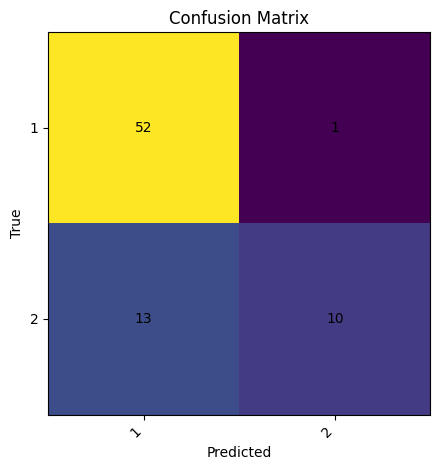

In [8]:
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,str(v), ha="center", va="center")
plt.tight_layout()
plt.show()


## 6) Output Artefak

- `mobilenet_baseline.pth` (model baseline)